# CS 224D Assignment #2
# Part [1]: Deep Networks: NER Window Model

For this first part of the assignment, you'll build your first "deep" networks. On problem set 1, you computed the backpropagation gradient $\frac{\partial J}{\partial w}$ for a two-layer network; in this problem set you'll implement a slightly more complex network to perform  named entity recognition (NER).

Before beginning the programming section, you should complete parts (a) and (b) of the corresponding section of the handout.

In [2]:
import sys, os
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## (c): Random Initialization Test
Use the cell below to test your code.

In [3]:
from misc import random_weight_matrix
random.seed(10)
print random_weight_matrix(3,5)

[[ 0.46994114 -0.83008197  0.23148553  0.43094097 -0.00258593]
 [-0.47666619 -0.52297046  0.45125243 -0.57311684 -0.71301636]
 [ 0.32105262  0.78530031 -0.85918681  0.02111762  0.54147539]]


## (d): Implementation

We've provided starter code to load in the dataset and convert it to a list of "windows", consisting of indices into the matrix of word vectors. 

We pad each sentence with begin and end tokens `<s>` and `</s>`, which have their own word vector representations; additionally, we convert all words to lowercase, canonicalize digits (e.g. `1.12` becomes `DG.DGDG`), and replace unknown words with a special token `UUUNKKK`.

You don't need to worry about the details of this, but you can inspect the `docs` variables or look at the raw data (in plaintext) in the `./data/` directory.

In [4]:
import data_utils.utils as du
import data_utils.ner as ner

In [5]:
# Load the starter word vectors
wv, word_to_num, num_to_word = ner.load_wv('data/ner/vocab.txt',
                                           'data/ner/wordVectors.txt')
tagnames = ["O", "LOC", "MISC", "ORG", "PER"]
num_to_tag = dict(enumerate(tagnames))
tag_to_num = du.invert_dict(num_to_tag)

# Set window size
windowsize = 3

# Load the training set
docs = du.load_dataset('data/ner/train')
X_train, y_train = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                      wsize=windowsize)

# Load the dev set (for tuning hyperparameters)
docs = du.load_dataset('data/ner/dev')
X_dev, y_dev = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                  wsize=windowsize)

# Load the test set (dummy labels only)
docs = du.load_dataset('data/ner/test.masked')
X_test, y_test = du.docs_to_windows(docs, word_to_num, tag_to_num,
                                    wsize=windowsize)

To avoid re-inventing the wheel, we provide a base class that handles a lot of the drudgery of managing parameters and running gradient descent. It's based on the classifier API used by [`scikit-learn`](http://scikit-learn.org/stable/), so if you're familiar with that library it should be easy to use. 

We'll be using this class for the rest of this assignment, so it helps to get acquainted with a simple example that should be familiar from Assignment 1. To keep this notebook uncluttered, we've put the code in the `softmax_example.py`; take a look at it there, then run the cell below.

In [6]:
from softmax_example import SoftmaxRegression
sr = SoftmaxRegression(wv=zeros((10,100)), dims=(100,5))

##
# Automatic gradient checker!
# this checks anything you add to self.grads or self.sgrads
# using the method of Assignment 1
sr.grad_check(x=5, y=4)

grad_check: dJ/db error norm = 3.565e-10 [ok]
    b dims: [5L] = 5 elem
grad_check: dJ/dW error norm = 2.164e-11 [ok]
    W dims: [5L, 100L] = 500 elem
grad_check: dJ/dL[5] error norm = 2.646e-11 [ok]
    L[5] dims: [100L] = 100 elem


In order to implement a model, you need to subclass `NNBase`, then implement the following methods:

- `__init__()` (initialize parameters and hyperparameters)
- `_acc_grads()` (compute and accumulate gradients)
- `compute_loss()` (compute loss for a training example)
- `predict()`, `predict_proba()`, or other prediction method (for evaluation)

`NNBase` provides you with a few others that will be helpful:

- `grad_check()` (run a gradient check - calls `_acc_grads` and `compute_loss`)
- `train_sgd()` (run SGD training; more on this later)

Your task is to implement the window model in `nerwindow.py`; a scaffold has been provided for you with instructions on what to fill in.

When ready, you can test below:

In [7]:
from nerwindow import WindowMLP
clf = WindowMLP(wv, windowsize=windowsize, dims=[None, 100, 5],
                reg=0.001, alpha=0.01)
clf.grad_check(X_train[0], y_train[0])  # gradient check on single point

grad_check: dJ/db2 error norm = 3.23e-10 [ok]
    b2 dims: [5L] = 5 elem
grad_check: dJ/dU error norm = 2.839e-10

 [ok]
    U dims: [5L, 100L] = 500 elem
grad_check: dJ/db1 error norm = 2.85e-09 [ok]
    b1 dims: [100L] = 100 elem
grad_check: dJ/dW error norm = 1.337e-08

 [ok]
    W dims: [100L, 150L] = 15000 elem
grad_check: dJ/dL[30] error norm = 3.461e-11 [ok]
    L[30] dims: [50L] = 50 elem
grad_check: dJ/dL[6659] error norm = 4.373e-11 [ok]
    L[6659] dims: [50L] = 50 elem
grad_check: dJ/dL[12637] error norm = 4.525e-11

 [ok]
    L[12637] dims: [50L] = 50 elem


Now we'll train your model on some data! You can implement your own SGD method, but we recommend that you just call `clf.train_sgd`. This takes the following arguments:

- `X`, `y` : training data
- `idxiter`: iterable (list or generator) that gives index (row of X) of training examples in the order they should be visited by SGD
- `printevery`: int, prints progress after this many examples
- `costevery`: int, computes mean loss after this many examples. This is a costly operation, so don't make this too frequent!

The implementation we give you supports minibatch learning; if `idxiter` is a list-of-lists (or yields lists), then gradients will be computed for all indices in a minibatch before modifying the parameters (this is why we have you write `_acc_grad` instead of applying them directly!).

Before training, you should generate a training schedule to pass as `idxiter`. If you know how to use Python generators, we recommend those; otherwise, just make a static list. Make the following in the cell below:

- An "epoch" schedule that just iterates through the training set, in order, `nepoch` times.
- A random schedule of `N` examples sampled with replacement from the training set.
- A random schedule of `N/k` minibatches of size `k`, sampled with replacement from the training set.

In [8]:
nepoch = 5
N = nepoch * len(y_train)
k = 5 # minibatch size

random.seed(10) # do not change this!
#### YOUR CODE HERE ####

max_iters = 100000

idxs = range(len(y_train))

# repeat the indices nepoch times
idx_epoch = nepoch * idxs

# choose N random points
idx_N = random.choice(idxs, N)

# make generator for N/k minibatches
def idx_batches():
    for i in xrange(N / k): yield random.choice(idxs, k)

#### END YOUR CODE ###

In [138]:
clf.train_sgd(X_train, y_train, idxiter=xrange(max_iters), costevery=5000)

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 0.438661


  [5000]: mean loss 0.428996


  Seen 10000 in 9.40 s


  [10000]: mean loss 0.434167


  [15000]: mean loss 0.459668


  Seen 20000 in 18.71 s


  [20000]: mean loss 0.371658


  [25000]: mean loss 0.384725


  Seen 30000 in 28.13 s


  [30000]: mean loss 0.404473


  [35000]: mean loss 0.657569


  Seen 40000 in 37.04 s


  [40000]: mean loss 0.417788


  [45000]: mean loss 0.371288


  Seen 50000 in 45.93 s


  [50000]: mean loss 0.407846


  [55000]: mean loss 0.46483


  Seen 60000 in 54.92 s


  [60000]: mean loss 0.362887


  [65000]: mean loss 0.508973


  Seen 70000 in 63.92 s


  [70000]: mean loss 0.488808


  [75000]: mean loss 0.372667


  Seen 80000 in 72.83 s


  [80000]: mean loss 0.339659


  [85000]: mean loss 0.340464


  Seen 90000 in 81.80 s


  [90000]: mean loss 0.361863


  [95000]: mean loss 0.354329


  [100000]: mean loss 0.320209


SGD complete: 100000 examples in 94.17 seconds.


[(0, 0.43866050475065216),
 (5000, 0.42899578300879143),
 (10000, 0.43416679641845118),
 (15000, 0.45966820754009191),
 (20000, 0.37165849666946149),
 (25000, 0.3847245349986656),
 (30000, 0.404472939168454),
 (35000, 0.65756892141233836),
 (40000, 0.41778836493922566),
 (45000, 0.37128756010197944),
 (50000, 0.40784566882986034),
 (55000, 0.46482953521420672),
 (60000, 0.36288735620623996),
 (65000, 0.50897316556736882),
 (70000, 0.48880836106382031),
 (75000, 0.37266719865750314),
 (80000, 0.33965910955133455),
 (85000, 0.3404644181292929),
 (90000, 0.36186276607933021),
 (95000, 0.35432935364952733),
 (100000, 0.3202086252348344)]

Now call `train_sgd` to train on `X_train`, `y_train`. To verify that things work, train on 100,000 examples or so to start (with any of the above schedules). This shouldn't take more than a couple minutes, and you should get a mean cross-entropy loss around 0.4.

Now, if this works well, it's time for production! You have three tasks here:

1. Train a good model
2. Plot a learning curve (cost vs. # of iterations)
3. Use your best model to predict the test set

You should train on the `train` data and evaluate performance on the `dev` set. The `test` data we provided has only dummy labels (everything is `O`); we'll compare your predictions to the true labels at grading time. 

Scroll down to section (f) for the evaluation code.

We don't expect you to spend too much time doing an exhaustive search here; the default parameters should work well, although you can certainly do better. Try to achieve an F1 score of at least 76% on the dev set, as reported by `eval_performance`.

Feel free to create new cells and write new code here, including new functions (helpers and otherwise) in `nerwindow.py`. When you have a good model, follow the instructions below to make predictions on the test set.

A strong model may require 10-20 passes (or equivalent number of random samples) through the training set and could take 20 minutes or more to train - but it's also possible to be much, much faster!

Things you may want to tune:
- `alpha` (including using an "annealing" schedule to decrease the learning rate over time)
- training schedule and minibatch size
- regularization strength
- hidden layer dimension
- width of context window

In [18]:
#### YOUR CODE HERE ####
# Sandbox: build a good model by tuning hyperparameters
from nerwindow import full_report, eval_performance

nepoch = 21
N = nepoch * len(y_train)
k = 3  # minibatch size

random.seed(10)  # do not change this!

batch_schedule = random.randint(0, len(y_train), N)

clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.0001, alpha=0.01)
traincurvebest = clf.train_sgd(X_train, y_train, idxiter=batch_schedule.reshape((N/k, k)), costevery=10000)
y_hat = clf.predict(X_dev)
full_report(y_dev, y_hat, tagnames)
eval_performance(y_dev, y_hat, tagnames)

#### END YOUR CODE ####

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988


  Seen 10000 in 9.77 s


  [10000]: mean loss 0.335743


  Seen 20000 in 20.64 s


  [20000]: mean loss 0.298726


  Seen 30000 in 30.12 s


  [30000]: mean loss 0.279629


  Seen 40000 in 39.52 s


  [40000]: mean loss 0.262145


  Seen 50000 in 48.77 s


  [50000]: mean loss 0.23218


  Seen 60000 in 58.46 s


  [60000]: mean loss 0.227118


  Seen 70000 in 68.07 s


  [70000]: mean loss 0.209058


  Seen 80000 in 77.34 s


  [80000]: mean loss 0.201542


  Seen 90000 in 86.64 s


  [90000]: mean loss 0.190813


  Seen 100000 in 96.79 s


  [100000]: mean loss 0.171713


  Seen 110000 in 106.85 s


  [110000]: mean loss 0.167137


  Seen 120000 in 116.49 s


  [120000]: mean loss 0.164789


  Seen 130000 in 126.05 s


  [130000]: mean loss 0.151085


  Seen 140000 in 135.24 s


  [140000]: mean loss 0.145194


  Seen 150000 in 144.41 s


  [150000]: mean loss 0.135311


  Seen 160000 in 153.62 s


  [160000]: mean loss 0.131517


  Seen 170000 in 162.73 s


  [170000]: mean loss 0.126976


  Seen 180000 in 172.00 s


  [180000]: mean loss 0.126042


  Seen 190000 in 181.14 s


  [190000]: mean loss 0.119423


  Seen 200000 in 190.34 s


  [200000]: mean loss 0.115463


  Seen 210000 in 199.56 s


  [210000]: mean loss 0.115202


  Seen 220000 in 208.65 s


  [220000]: mean loss 0.110329


  Seen 230000 in 217.84 s


  [230000]: mean loss 0.108964


  Seen 240000 in 226.88 s


  [240000]: mean loss 0.108195


  Seen 250000 in 236.01 s


  [250000]: mean loss 0.100564


  Seen 260000 in 245.29 s


  [260000]: mean loss 0.104136


  Seen 270000 in 254.47 s


  [270000]: mean loss 0.0954664


  Seen 280000 in 263.67 s


  [280000]: mean loss 0.0992419


  Seen 290000 in 272.80 s


  [290000]: mean loss 0.0934818


  Seen 300000 in 282.02 s


  [300000]: mean loss 0.0909986


  Seen 310000 in 291.33 s


  [310000]: mean loss 0.0949549


  Seen 320000 in 300.52 s


  [320000]: mean loss 0.0904861


  Seen 330000 in 309.62 s


  [330000]: mean loss 0.0890684


  Seen 340000 in 318.78 s


  [340000]: mean loss 0.0860453


  Seen 350000 in 327.95 s


  [350000]: mean loss 0.0849666


  Seen 360000 in 337.21 s


  [360000]: mean loss 0.0836993


  Seen 370000 in 346.45 s


  [370000]: mean loss 0.0957291


  Seen 380000 in 355.60 s


  [380000]: mean loss 0.0846682


  Seen 390000 in 364.80 s


  [390000]: mean loss 0.082277


  Seen 400000 in 374.05 s


  [400000]: mean loss 0.0801644


  Seen 410000 in 383.24 s


  [410000]: mean loss 0.0810855


  Seen 420000 in 392.57 s


  [420000]: mean loss 0.0761975


  Seen 430000 in 401.77 s


  [430000]: mean loss 0.0784379


  Seen 440000 in 410.99 s


  [440000]: mean loss 0.0763745


  Seen 450000 in 420.24 s


  [450000]: mean loss 0.0778269


  Seen 460000 in 429.41 s


  [460000]: mean loss 0.0753084


  Seen 470000 in 438.54 s


  [470000]: mean loss 0.0736138


  Seen 480000 in 447.60 s


  [480000]: mean loss 0.0757045


  Seen 490000 in 456.66 s


  [490000]: mean loss 0.0757939


  Seen 500000 in 465.81 s


  [500000]: mean loss 0.0689681


  Seen 510000 in 475.14 s


  [510000]: mean loss 0.072724


  Seen 520000 in 484.29 s


  [520000]: mean loss 0.0670854


  Seen 530000 in 493.44 s


  [530000]: mean loss 0.0686724


  Seen 540000 in 502.62 s


  [540000]: mean loss 0.0723133


  Seen 550000 in 511.83 s


  [550000]: mean loss 0.0683796


  Seen 560000 in 521.10 s


  [560000]: mean loss 0.0676103


  Seen 570000 in 530.45 s


  [570000]: mean loss 0.0662432


  Seen 580000 in 539.60 s


  [580000]: mean loss 0.0668945


  Seen 590000 in 548.84 s


  [590000]: mean loss 0.0636274


  Seen 600000 in 558.14 s


  [600000]: mean loss 0.0693876


  Seen 610000 in 567.32 s


  [610000]: mean loss 0.0679253


  Seen 620000 in 576.49 s


  [620000]: mean loss 0.0625803


  Seen 630000 in 585.53 s


  [630000]: mean loss 0.0634273


  Seen 640000 in 594.73 s


  [640000]: mean loss 0.0650066


  Seen 650000 in 604.01 s


  [650000]: mean loss 0.0669316


  Seen 660000 in 613.20 s


  [660000]: mean loss 0.0625378


  Seen 670000 in 622.37 s


  [670000]: mean loss 0.0615573


  Seen 680000 in 631.53 s


  [680000]: mean loss 0.059206


  Seen 690000 in 640.67 s


  [690000]: mean loss 0.0605349


  Seen 700000 in 649.81 s


  [700000]: mean loss 0.0632212


  Seen 710000 in 658.93 s


  [710000]: mean loss 0.0596109


  Seen 720000 in 668.08 s


  [720000]: mean loss 0.0579568


  Seen 730000 in 677.12 s


  [730000]: mean loss 0.0569868


  Seen 740000 in 686.34 s


  [740000]: mean loss 0.0607047


  Seen 750000 in 695.56 s


  [750000]: mean loss 0.0594539


  Seen 760000 in 704.81 s


  [760000]: mean loss 0.0578441


  Seen 770000 in 713.94 s


  [770000]: mean loss 0.0535682


  Seen 780000 in 723.10 s


  [780000]: mean loss 0.05582


  Seen 790000 in 732.32 s


  [790000]: mean loss 0.0568781


  Seen 800000 in 741.46 s


  [800000]: mean loss 0.0587521


  Seen 810000 in 750.57 s


  [810000]: mean loss 0.0546287


  Seen 820000 in 759.71 s


  [820000]: mean loss 0.0522787


  Seen 830000 in 768.99 s


  [830000]: mean loss 0.0546301


  Seen 840000 in 778.26 s


  [840000]: mean loss 0.0583642


  Seen 850000 in 787.44 s


  [850000]: mean loss 0.0554176


  Seen 860000 in 796.54 s


  [860000]: mean loss 0.0521844


  Seen 870000 in 805.75 s


  [870000]: mean loss 0.0524232


  Seen 880000 in 814.90 s


  [880000]: mean loss 0.0517318


  Seen 890000 in 824.08 s


  [890000]: mean loss 0.0543894


  Seen 900000 in 833.19 s


  [900000]: mean loss 0.0600636


  Seen 910000 in 842.40 s


  [910000]: mean loss 0.0541662


  Seen 920000 in 851.57 s


  [920000]: mean loss 0.0558336


  Seen 930000 in 860.78 s


  [930000]: mean loss 0.0524456


  Seen 940000 in 869.91 s


  [940000]: mean loss 0.0490752


  Seen 950000 in 879.09 s


  [950000]: mean loss 0.0512266


  Seen 960000 in 888.39 s


  [960000]: mean loss 0.0488085


  Seen 970000 in 897.53 s


  [970000]: mean loss 0.0496357


  Seen 980000 in 906.68 s


  [980000]: mean loss 0.0515697


  Seen 990000 in 915.84 s


  [990000]: mean loss 0.0475045


  Seen 1000000 in 925.13 s


  [1000000]: mean loss 0.0496261


  Seen 1010000 in 934.37 s


  [1010000]: mean loss 0.0477743


  Seen 1020000 in 943.52 s


  [1020000]: mean loss 0.0468239


  Seen 1030000 in 952.75 s


  [1030000]: mean loss 0.0481415


  Seen 1040000 in 961.96 s


  [1040000]: mean loss 0.0462188


  Seen 1050000 in 971.06 s


  [1050000]: mean loss 0.0478887


  Seen 1060000 in 980.17 s


  [1060000]: mean loss 0.0444434


  Seen 1070000 in 989.40 s


  [1070000]: mean loss 0.0485094


  Seen 1080000 in 998.50 s


  [1080000]: mean loss 0.0472893


  Seen 1090000 in 1007.61 s


  [1090000]: mean loss 0.051056


  Seen 1100000 in 1016.78 s


  [1100000]: mean loss 0.048125


  Seen 1110000 in 1025.89 s


  [1110000]: mean loss 0.0562237


  Seen 1120000 in 1034.98 s


  [1120000]: mean loss 0.0453289


  Seen 1130000 in 1044.25 s


  [1130000]: mean loss 0.0464868


  Seen 1140000 in 1053.27 s


  [1140000]: mean loss 0.0452285


  Seen 1150000 in 1062.48 s


  [1150000]: mean loss 0.0499822


  Seen 1160000 in 1071.51 s


  [1160000]: mean loss 0.0477112


  Seen 1170000 in 1080.81 s


  [1170000]: mean loss 0.0470438


  Seen 1180000 in 1089.94 s


  [1180000]: mean loss 0.0460247


  Seen 1190000 in 1099.14 s


  [1190000]: mean loss 0.045937


  Seen 1200000 in 1108.24 s


  [1200000]: mean loss 0.0473443


  Seen 1210000 in 1117.49 s


  [1210000]: mean loss 0.0462028


  Seen 1220000 in 1126.72 s


  [1220000]: mean loss 0.0441521


  Seen 1230000 in 1135.97 s


  [1230000]: mean loss 0.047044


  Seen 1240000 in 1145.10 s


  [1240000]: mean loss 0.0439697


  Seen 1250000 in 1154.19 s


  [1250000]: mean loss 0.0444617


  Seen 1260000 in 1163.34 s


  [1260000]: mean loss 0.0436266


  Seen 1270000 in 1172.49 s


  [1270000]: mean loss 0.0441253


  Seen 1280000 in 1181.62 s


  [1280000]: mean loss 0.0438285


  Seen 1290000 in 1190.83 s


  [1290000]: mean loss 0.0426807


  Seen 1300000 in 1200.02 s


  [1300000]: mean loss 0.0536219


  Seen 1310000 in 1209.22 s


  [1310000]: mean loss 0.045473


  Seen 1320000 in 1218.33 s


  [1320000]: mean loss 0.0449306


  Seen 1330000 in 1227.38 s


  [1330000]: mean loss 0.0426112


  Seen 1340000 in 1236.52 s


  [1340000]: mean loss 0.0445495


  Seen 1350000 in 1245.65 s


  [1350000]: mean loss 0.0442451


  Seen 1360000 in 1254.86 s


  [1360000]: mean loss 0.0430002


  Seen 1370000 in 1264.02 s


  [1370000]: mean loss 0.0481098


  Seen 1380000 in 1273.14 s


  [1380000]: mean loss 0.0486179


  Seen 1390000 in 1282.16 s


  [1390000]: mean loss 0.0413022


  Seen 1400000 in 1291.36 s


  [1400000]: mean loss 0.0405736


  Seen 1410000 in 1300.50 s


  [1410000]: mean loss 0.0422806


  Seen 1420000 in 1309.67 s


  [1420000]: mean loss 0.0432107


  [1425347]: mean loss 0.0434628


SGD complete: 1425347 examples in 1319.77 seconds.
             precision    recall  f1-score   support

          O       0.97      0.99      0.98     42759
        LOC       0.89      0.84      0.87      2094
       MISC       0.87      0.74      0.80      1268
        ORG       0.73      0.69      0.71      2092
        PER       0.93      0.76      0.84      3149

avg / total       0.95      0.95      0.95     51362



=== Performance (omitting 'O' class) ===
Mean precision:  86.24%
Mean recall:     76.08%
Mean F1:         80.74%


## (e): Plot Learning Curves
The `train_sgd` function returns a list of points `(counter, cost)` giving the mean loss after that number of SGD iterations.

If the model is taking too long you can cut it off by going to *Kernel->Interrupt* in the IPython menu; `train_sgd` will return the training curve so-far, and you can restart without losing your training progress.

Make two plots:

- Learning curve using `reg = 0.001`, and comparing the effect of changing the learning rate: run with `alpha = 0.01` and `alpha = 0.1`. Use minibatches of size 5, and train for 10,000 minibatches with `costevery=200`. Be sure to scale up your counts (x-axis) to reflect the batch size. What happens if the model tries to learn too fast? Explain why this occurs, based on the relation of SGD to the true objective.

- Learning curve for your best model (print the hyperparameters in the title), as trained using your best schedule. Set `costevery` so that you get at least 100 points to plot.

In [9]:
from nerwindow import full_report, eval_performance

nepoch = 3
N = nepoch * len(y_train)
k = 3  # minibatch size

random.seed(10)  # do not change this!

batch_schedule = random.randint(0, len(y_train), N)

clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.001, alpha=0.01)
traincurve1 = clf.train_sgd(X_train, y_train, idxiter=batch_schedule.reshape((N/k, k)), costevery=5000)
y_hat = clf.predict(X_dev)
full_report(y_dev, y_hat, tagnames)
eval_performance(y_dev, y_hat, tagnames)

clf = WindowMLP(wv, windowsize=3, dims=[None, 100, 5], reg=0.001, alpha=0.1)
traincurve2 = clf.train_sgd(X_train, y_train, idxiter=batch_schedule.reshape((N/k, k)), costevery=5000)
y_hat = clf.predict(X_dev)
full_report(y_dev, y_hat, tagnames)
eval_performance(y_dev, y_hat, tagnames)

Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988


  [5000]: mean loss 0.358253


  Seen 10000 in 12.72 s


  [10000]: mean loss 0.33883


  [15000]: mean loss 0.31967


  Seen 20000 in 25.36 s


  [20000]: mean loss 0.307078


  [25000]: mean loss 0.314051


  Seen 30000 in 38.03 s


  [30000]: mean loss 0.292804


  [35000]: mean loss 0.275745


  Seen 40000 in 50.88 s


  [40000]: mean loss 0.277554


  [45000]: mean loss 0.2748


  Seen 50000 in 63.45 s


  [50000]: mean loss 0.255475


  [55000]: mean loss 0.254498


  Seen 60000 in 76.08 s


  [60000]: mean loss 0.254944


  [65000]: mean loss 0.240386


  Seen 70000 in 88.51 s


  [70000]: mean loss 0.234078


  [75000]: mean loss 0.231649


  Seen 80000 in 101.24 s


  [80000]: mean loss 0.230566


  [85000]: mean loss 0.238596


  Seen 90000 in 114.32 s


  [90000]: mean loss 0.220366


  [95000]: mean loss 0.217629


  Seen 100000 in 127.19 s


  [100000]: mean loss 0.2067


  [105000]: mean loss 0.20448


  Seen 110000 in 139.80 s


  [110000]: mean loss 0.200461


  [115000]: mean loss 0.197707


  Seen 120000 in 152.36 s


  [120000]: mean loss 0.199077


  [125000]: mean loss 0.204257


  Seen 130000 in 164.95 s


  [130000]: mean loss 0.186434


  [135000]: mean loss 0.187823


  Seen 140000 in 177.62 s


  [140000]: mean loss 0.18696


  [145000]: mean loss 0.177767


  Seen 150000 in 190.03 s


  [150000]: mean loss 0.175703


  [155000]: mean loss 0.174805


  Seen 160000 in 202.51 s


  [160000]: mean loss 0.174456


  [165000]: mean loss 0.170467


  Seen 170000 in 215.11 s


  [170000]: mean loss 0.168105


  [175000]: mean loss 0.165632


  Seen 180000 in 227.59 s


  [180000]: mean loss 0.170124


  [185000]: mean loss 0.164943


  Seen 190000 in 239.94 s


  [190000]: mean loss 0.161913


  [195000]: mean loss 0.171091


  Seen 200000 in 252.37 s


  [200000]: mean loss 0.159533


  [203621]: mean loss 0.159294


SGD complete: 203621 examples in 261.24 seconds.
             precision    recall  f1-score   support

          O       0.96      0.98      0.97     42759
        LOC       0.78      0.83      0.80      2094
       MISC       0.82      0.63      0.71      1268
        ORG       0.65      0.56      0.60      2092
        PER       0.87      0.75      0.81      3149

avg / total       0.93      0.94      0.93     51362



=== Performance (omitting 'O' class) ===
Mean precision:  78.90%
Mean recall:     70.39%
Mean F1:         74.19%
Begin SGD...
  Seen 0 in 0.00 s
  [0]: mean loss 1.77988


  [5000]: mean loss 0.844157


  Seen 10000 in 12.70 s


  [10000]: mean loss 0.563162


  [15000]: mean loss 0.412524


  Seen 20000 in 25.57 s


  [20000]: mean loss 0.324245


  [25000]: mean loss 0.277869


  Seen 30000 in 38.45 s


  [30000]: mean loss 0.292829


  [35000]: mean loss 0.223868


  Seen 40000 in 51.76 s


  [40000]: mean loss 0.291641


  [45000]: mean loss 0.236791


  Seen 50000 in 64.85 s


  [50000]: mean loss 0.204955


  [55000]: mean loss 0.276852


  Seen 60000 in 77.98 s


  [60000]: mean loss 0.186718


  [65000]: mean loss 0.219226


  Seen 70000 in 92.37 s


  [70000]: mean loss 0.221071


  [75000]: mean loss 0.191679


  Seen 80000 in 105.91 s


  [80000]: mean loss 0.232493


  [85000]: mean loss 0.208572


  Seen 90000 in 119.08 s


  [90000]: mean loss 0.179033


  [95000]: mean loss 0.184264


  Seen 100000 in 132.31 s


  [100000]: mean loss 0.186865


  [105000]: mean loss 0.167725


  Seen 110000 in 145.95 s


  [110000]: mean loss 0.176292


  [115000]: mean loss 0.188384


  Seen 120000 in 158.63 s


  [120000]: mean loss 0.166423


  [125000]: mean loss 0.157809


  Seen 130000 in 171.22 s


  [130000]: mean loss 0.179062


  [135000]: mean loss 0.173891


  Seen 140000 in 184.89 s


  [140000]: mean loss 0.154022


  [145000]: mean loss 0.146536


  Seen 150000 in 198.55 s


  [150000]: mean loss 0.148962


  [155000]: mean loss 0.159787


  Seen 160000 in 212.00 s


  [160000]: mean loss 0.149863


  [165000]: mean loss 0.153327


  Seen 170000 in 224.67 s


  [170000]: mean loss 0.145878


  [175000]: mean loss 0.131442


  Seen 180000 in 238.91 s


  [180000]: mean loss 0.147832


  [185000]: mean loss 0.15379


  Seen 190000 in 252.39 s


  [190000]: mean loss 0.124411


  [195000]: mean loss 0.145164


  Seen 200000 in 265.47 s


  [200000]: mean loss 0.137188


  [203621]: mean loss 0.136851


SGD complete: 203621 examples in 274.92 seconds.
             precision    recall  f1-score   support

          O       0.95      0.98      0.97     42759
        LOC       0.84      0.79      0.82      2094
       MISC       0.72      0.75      0.73      1268
        ORG       0.70      0.56      0.62      2092
        PER       0.94      0.66      0.78      3149

avg / total       0.93      0.93      0.93     51362



=== Performance (omitting 'O' class) ===
Mean precision:  82.53%
Mean recall:     68.20%
Mean F1:         74.29%


nn\base.py:419: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idxiter == None: # default training schedule


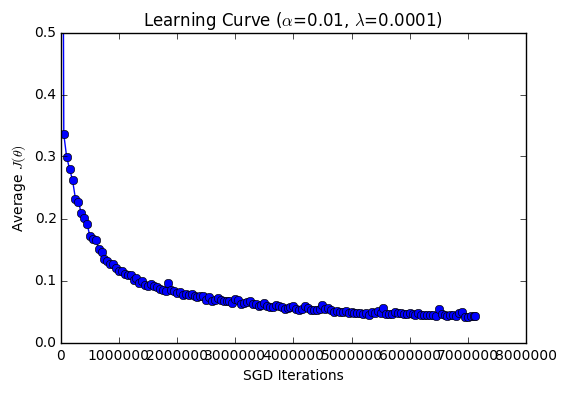

In [19]:
##
# Plot your best learning curve here
counts, costs = zip(*traincurvebest)
figure(figsize=(6,4))
plot(5*array(counts), costs, color='b', marker='o', linestyle='-')
title(r"Learning Curve ($\alpha$=%g, $\lambda$=%g)" % (clf.alpha, clf.lreg))
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
ylim(0,0.5)

# Don't change this filename!
savefig("ner.learningcurve.best.png")

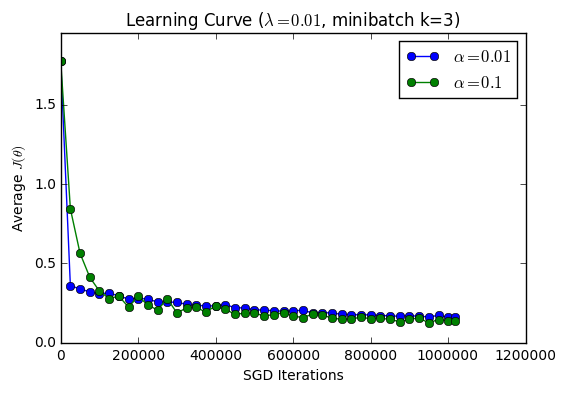

In [12]:
##
# Plot comparison of learning rates here
# feel free to change the code below

figure(figsize=(6,4))
counts, costs = zip(*traincurve1)
plot(5*array(counts), costs, color='b', marker='o', linestyle='-', label=r"$\alpha=0.01$")
counts, costs = zip(*traincurve2)
plot(5*array(counts), costs, color='g', marker='o', linestyle='-', label=r"$\alpha=0.1$")
title(r"Learning Curve ($\lambda=0.01$, minibatch k=3)")
xlabel("SGD Iterations"); ylabel(r"Average $J(\theta)$"); 
ylim(ymin=0, ymax=max(1.1*max(costs),3*min(costs)));
legend()

# Don't change this filename
savefig("ner.learningcurve.comparison.png")

## (f): Evaluating your model
Evaluate the model on the dev set using your `predict` function, and compute performance metrics below!

In [20]:
# Predict labels on the dev set
yp = clf.predict(X_dev)
# Save predictions to a file, one per line
ner.save_predictions(yp, "dev.predicted")

In [21]:
from nerwindow import full_report, eval_performance
full_report(y_dev, yp, tagnames) # full report, helpful diagnostics
eval_performance(y_dev, yp, tagnames) # performance: optimize this F1

             precision    recall  f1-score   support

          O       0.97      0.99      0.98     42759
        LOC       0.89      0.84      0.87      2094
       MISC       0.87      0.74      0.80      1268
        ORG       0.73      0.69      0.71      2092
        PER       0.93      0.76      0.84      3149

avg / total       0.95      0.95      0.95     51362

=== Performance (omitting 'O' class) ===
Mean precision:  86.24%
Mean recall:     76.08%
Mean F1:         80.74%


In [22]:
# Save your predictions on the test set for us to evaluate
# IMPORTANT: make sure X_test is exactly as loaded 
# from du.docs_to_windows, so that your predictions 
# line up with ours.
yptest = clf.predict(X_test)
ner.save_predictions(yptest, "test.predicted")